# Initial Time and Frequency Synchronization

In realistic digital communication systems, several signal parameters are unknown, including
* signal amplitude $A$
* carrier phase $\phi$
* carrier frequency offset $\Delta f$
* signal delay $\tau$

The receiver can **not** recover the information symbols without knowing and correcting for these unknow signal parameters.

The unknown signal parameters must be measured (estimated) from the received signal. Usually, this is accomplished by sending a training sequence of known symbols before the information bearing signal.

Signal parameters are determined from this training sequence and are then used to enable the transmitter to receive the information symbols.

Today, we show how the training sequence can be leveraged to learn where in the reeived stream of samples the signal starts. Armed with that information, we will estimate the frequency offset (as well as the amplitude and phase).

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/060_initial_synch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/060_initial_synch.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

from typing import Tuple

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# the next cells, repeat code from earlier notebooks. It would be better to import these but
# then the notebook is no longer self-contained

In [2]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [3]:
def srrc_pulse(a, fsT, N=5):
    """Construct a raised cosine pulse
    
    Inputs:
    a - roll-off factor
    fsT - number of samples per symbol period
    N - lenght of pulse in symbol periods; pulse ranges for -N \leq t/T \leq N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/(fs*T)
    tt = np.linspace(-N, N, 2*N*fsT + 1)
    
    num = np.sin(np.pi*tt*(1-a)) + 4*a*tt*np.cos(np.pi*tt*(1+a))
    den = np.pi*tt*(1-(4*a*tt)**2)
    
    # deal with divide-by-zeros: at zero location, place "L'Hospital value" in numerator
    # and 1 in denominator.
    # First divide-by-zero location is t=0; by L-Hospital, the value is (1 + a*(4/pi - 1))
    ind_0 = np.where(np.abs(tt) < 1e-6)
    num[ind_0] = (1 + a*(4/np.pi - 1))
    den[ind_0] = 1
    # Second divide-by-zero location is t=+/-1/(4*a); by L-Hospital, the value is as shown below
    ind_0 = np.where(np.abs(np.abs(tt) - 1/(4*a)) < 1e-6)
    num[ind_0] = a/np.sqrt(2) * ((1+2/np.pi)*np.sin(np.pi/(4*a)) + (1-2/np.pi)*np.cos(np.pi/(4*a)))
    den[ind_0] = 1
    
    # scaling: we scale the pulse such that the convolution of two SRRC pulse yields
    # a RC pulse with amplitude 1 in the center of the pulse. This implies that
    # np.sum(hh**2) must equal 1. This replace the scaling by 1/T in the formula above.
    hh = num/den
    
    return hh / np.sqrt(np.sum(hh*hh))

In [4]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

In [5]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec

## Sequences for Signal Acquisition

The signal used in the preamble must have very good autocorrelation properties; in essence, we want the autoccorellation of these sequences to be impulse-like.

This gurantees that high correlation dduring the search for the start of the signal occurs only when the preamble in the received signal lines up with the reference preamble sequence itself. Any time-shift between the received preamble and the reference preamble should not produce a large correlation.

Since this is a fundamental and widely studied problem, sequences with good autocorrelation properties are well known. The best-known examples of good sequnces are 
* **M-sequences:** are generated by linear feedback shift registers (LFSR) using modulo-2 arithmetic (i.e., operating over the Galois field of size 2, GF(2)). The length of the shift register is denoted by $N$ bits. LFSR sequences are maximal length sequences (M-sequences)  if their period is $2^N-1$. The feeback pattern in the LFSR determines if an LFSR sequences is an M-sequence.
* **Gold-sequences**: are produced by combining shifted versions of two equal-length M-sequences. Gold-sequences inherit the good autocorrelation properties from the M-sequences. Additionally, a large number of different sequences with very good cross-correlation properties can be generated in this manner. Gold-sequences are used in GPS, for example.

### Examples of M-sequences and Gold Sequences

The 5G-NR standards use Gold codes as *Demodulation Reference Signals* (DMRS), i.e., as sequences intended to support channel estimation for the frequency domain equalizer. Below is an excerpt from TS 38.211:

>**5.2.1 Pseudo-random sequence generation**
>
>Generic pseudo-random sequences are defined by a length-31 Gold sequence. The output sequence $c(n)$ of length $M_{PN}$ ,where $n=0,1,\ldots,M_{PN} −1$,is defined by   
\begin{align}
c(n) & = (x_1(n + N_C ) + x_2(n + N_C )) \mod 2 \\
x_1(n + 31) & = (x_1(n + 3) + x_1(n)) \mod 2 \\
x_2( n + 3 1) & = ( x_2( n + 3 ) + x_2( n + 2 ) + x_2( n + 1) + x_2( n ) ) \mod 2
\end{align}
where $N_C=1600$ and thefirst m-sequence $x_1(n)$ shall be initialized with
$x_1(0)=1$, $x_1(n)=0$, $n=1,2,\ldots,30$.
The initialization of the second m-sequence, $x_2(n)$, is denoted by 
>$$
>c_{init}= \sum_{i=0}^{30} x_2(i) \cdot 2^i 
>$$
>with the value depending on the application of the sequence.

Above, $x_1(n)$ and $x_2(n)$ are M-sequences and $c(n)$ is a Gold sequence.

### Generating an M-Sequence

Let's consider the sequence $x_1(n)$ defined by
$$
x_1(n + 31)  = (x_1(n + 3) + x_1(n)) \mod 2.
$$

The above is a recursive equation that defines how a later element $x_1(n+31)$ is computed from elements that occur earlier in the sequence (here, $x_1(n + 3)$, $x_1(n)$).

We can think of this process in terms of a shift register that holds the values needed to compute the *feedback* from earlier elements, here $(x_1(n + 3) + x_1(n)) \mod 2$. This shift register must hold the 31 most recent values $x_1(n)$ through $x_1(n+30)$.

This feedback generates the newest element of the sequence $x_1(n + 31)$. This value is also inserted in the shift register (position 32).

At time $n$ and after computing the feedback value, the LFSR, thus, holds elements $x_1(n)$ through $x_1(n+31)$. 

The elemnt $x_1(n)$ is output and will not be needed further for computing feedback. Therefore, we can shift all elements in the register by one position so that the register now holds elements $x_1(n+1)$ through $x_1(n+32)$.

The process repeats by computing the feedback ($x_1(n + 4) + x_1(n+1) \mod 2$) for element $x_1(n+32)$.

A (naive) implementation of this process can be implemented as follows to geerate sequences $x_1$, $x_2$, and $c$: 

In [6]:
# quick and dirty implementation of pseudo-random sequence c(n)
def naive_x1(M: int, Nc: int):
    """Generate sequence x1"""
    x1 = np.zeros(M+Nc, dtype=np.uint8)
    
    # initialize
    x1[0] = 1
    x1[1:30] = 0
    
    # compute
    for n in range(31, M+Nc):
        x1[n] = x1[n-31] ^ x1[n-28]
        
    return x1[Nc:]

def naive_x2(M: int, c_init: int, Nc: int):
    """Generate sequence x2"""
    x2 = np.zeros(M+Nc, dtype=np.uint8)
    
    # initialize
    for k in range(31):
        x2[k] = (c_init & (1 << k)) >> k
        
    # compute
    for n in range(31, M+Nc):
        x2[n] = x2[n-31] ^ x2[n-30] ^ x2[n-29] ^ x2[n-28]
    
    return x2[Nc:]
                                         
    
def naive_cn(M: int, c_init: int, Nc:int = 1600):
    """Generate samples of pseudo-random sequence"""
    return naive_x1(M, Nc) ^ naive_x2(M, Nc, c_init)

### Test: check correlations

Specific examples for any of these sequences is not provided in the standard. In the absence of such ground truth for $c(n)$, we check that the pseudo-random sequence $c(n)$ has good correlation properties: both auto-correlation and cross-correlation should be low.

In [7]:
# pick two arbitrary values for c_init, then convert the binary (0,1)
# sequence to BPSK (1, -1)

N = 128 

c1 = 1.0 - 2.0 * naive_cn(N, 17) 
c2 = 1.0 - 2.0 * naive_cn(N, 18)

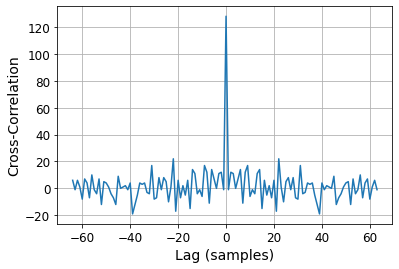

In [8]:
# compute auto-correlation of c1 
ac = np.correlate(c1, c1, 'same')

plt.plot(np.arange(N)-N/2, ac)
plt.grid()
plt.xlabel('Lag (samples)')
plt.ylabel('Cross-Correlation')
plt.show()

A very strong correlation peak is clearly visible at lag zero. Correlations at other lags are much smaller.

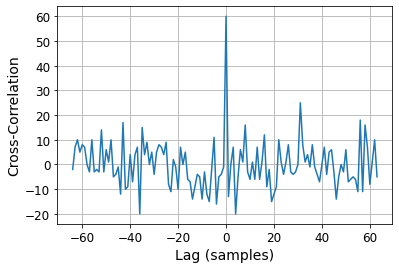

In [9]:
# compute cross-correlation between c1 and c2
xc = np.correlate(c1, c2, 'same')

plt.plot(np.arange(N)-N/2, xc)
plt.grid()
plt.xlabel('Lag (samples)')
plt.ylabel('Cross-Correlation')
plt.show()

The cross-correlation is modest at all lags. The cross-correlation is less important for today's discussion.

### A better way to generate M-sequences

The naive implementations above are not very good:
* each M-sequence needs a separate function
* the implementation is wasteful of memory space the entire sequence is stored; a shift register isn't actually used
* it is not very fast

A better approach is to
* actually use a shift register
* store the elements in the shift register compactly as the bits of a 32 bit integer
* make it faster by using bit-wise operation
* parameterize the function by specifying the initial register loading and also the feedback connections.

With these aims, we can write a generic LFSR function. This function needs a helper function `pop_count32` that counts the number of 1-bits in a 32-bit integer; the LSB of this result is used for computing the feedback bit.

In [10]:
def pop_count32(x: np.uint32) -> np.uint8:
    """count the number of 1s in 32-bit integer x using Wegner's method
    
    Inputs:
    x - a 32 bit integer

    Returns:
    an integer between 0 and 32 indicating the number of 1s in x
    """
    
    count: np.uint8 = 0
    
    while (x > 0):
        x = x & (x-1)
        count += 1
        
    return count

The function below computes a single sample of the LFSR sequence for a given shift register content (`state`) and feedback connection `fb`.

In [11]:
def lfsr_step(state: np.uint32, fb: np.uint32, N: int = 31) -> Tuple[np.uint8, np.uint32]:
    """Single update step of LFSR with feedback connections fb
    
    Inputs:
    * state (uint32): initial state of the feedback shift register
    * fb (uint32): bit map indicating feedback connections; the LSB corresponds to bit 0 in the LFSR
    * N (int) order if the LFSR; must be less than 32 (default: 31)
    
    Returns:
    * elem - next element of the LFSR sequence
    * state - updated state
    
    Example: Generate the first 10 elements of a LFSR sequence with fb=0b1001 and initial state=0b1111
    >>> state = 0b1111
    >>> seq = np.empty(10, dtype=np.uint8)
    >>> for n in range(10):
    >>>     seq[n], state = lfsr31_step(state, 0b1001)
    >>> seq
    
    array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)
    """
    
    # save the LSB before updating state; it will be returned
    elem: np.uint8 = state & 0b1
        
    # update state
    fb_vec: np.uint32 = state & fb
    fb_bit: np.uint8 = (pop_count32(fb_vec) & 0b1)
    
    # insert feedback bit at position N, then shift
    state = (state | fb_bit << N) >> 1
    
    return elem, state

#### How to set the feedback connections?

The feedback input `fb` is supposed to capture the feedback connections. 

For example, in sequence $x_1$ feedback is computed from elements $x_1(n)$ and $x_1(n+3)$.

In the LFSR iplemntation above, these elements are stored in bits 0 and 3 of the variable `state` that holds the shift register.

The feedback is computed by bit-wise and (`&`) of `state` and `fb`: `fb_vec = state & fb`.

Therefore, `fb` must contain 1-bits in positions 0 and 3. I.e., it must be equal to `0b1001` which equals the integer 9.

In general, the feedback value is an integer that contains 1-bits in the positions that correspond to elemnts that are used to compute the feedback bit. For example, for sequence $x_2$ the feedback is computed as
$$
x_2( n + 3 1)  = ( x_2( n + 3 ) + x_2( n + 2 ) + x_2( n + 1) + x_2( n ) ) \mod 2.
$$
Therefore the the appropriate value for `fb` is `0b1111` (decimal 15).

Below is a function to generate $M$ samples of an LFSR-sequence (starting with element $N$) for a giving initial value and feedback.

In [12]:
def lfsr(init: np.uint32, fb: np.uint32, M: int, N: int = 31, Nc:int = 0):
    """Compute M samples of a LFSR sequence
    
    Inputs:
    init - initial state of the LFSR
    fb - feedback connection for the LFSR
    M - number of samples to generate
    N - order of the LFSR (default: 31)
    Nc - statrting sample (default 0)

    Returns:
    length-M vector of bits (stored as np.uint8)
    """
    seq = np.empty(M, dtype=np.uint8)

    state = init

    for n in range(Nc):
        _, state = lfsr_step(state, fb, N)          # discard the first Nc

    for n in range(M):  
        seq[n], state = lfsr_step(state, fb, N)     # keep the next Mc

    return seq

In [13]:
# check that we get the same values as with the naive methods
assert np.alltrue (lfsr(1, 9, 1024, 31, 1600) == naive_x1(1024, 1600))
assert np.alltrue (lfsr(1, 15, 1024, 31, 1600) == naive_x2(1024, 1, 1600))

Examples of LFSR sequences that are maximal length sequences:

| order $N$ | Period $M$ | `fb` |
|-----------|------------|------|
| 4 | 15 | 3 |
| 5 | 31 | 5 |
| 6 | 63 | 3 |
| 7 | 127| 3 |

Sequences resulting from these choices for order $N$ and feedback `fb` are well-suited to generate signals for timing acquisition. The initial value for the shift register is not important in this context.

## Timing Acquisition

With good sequences to generate preamble signals in hand, we now turn our attention to actually find the location of the preamble within the received signal.

### Transmitted Signal

We begin by generating the preamble signal that the transmitter would send. For our illustration, the preamble length will span $M=31$ symbol periods. The preamble sequence will be the M-sequence with $N=5$ and `fb = 5`

The signal will be oversampled initially 32 times, i.e., $f_sT = 8$. However, we will down-sample it before the signal is presented to the receiver. This simplifies the delay simulation. Pulse-shaping with a SRRC ($\alpha=0.5$) filter is performed.

The training symbol is followed directly by a few information symbols.

In [14]:
## construct a suitable training signal followed by information symbols
# Parameters
fsT = 32    # tx oversampling
K = 31      # length of preamble
fb = 5      # LFSR feedback

A = np.array([1.0, -1.0], dtype=complex)
Ns = 32     # number of information symbols

hh = srrc_pulse(0.5, fsT)

# make preamble symbols and info symbols, then concatenate
pn = A[lfsr(1, fb, K, 5)]
syms = random_symbols(A, Ns)

sig = pulse_shape(np.concatenate((pn, syms)), hh, fsT)

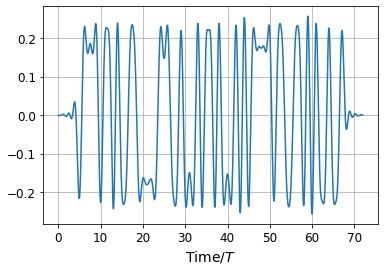

In [15]:
plt.plot(np.arange(len(sig))/fsT, sig.real)
plt.grid()

plt.xlabel('Time/$T$')
plt.show()

### Channel

The channel will introduce a delay, frequency and phase offset, and gain. These are the unknown parameters that the receiver must determine before it can process the information sequence.

After delaying the signal, it will be down-sampled. When we use a delay (in sample periods) that does not evenly divide the down-sampling factor, then no sampling phase will match the delay exactly. 

Obviously, the channel also introduces AWGN.

In [16]:
## channel parameters
delay_samples = 102
ds_factor = 4       # down-sample by 4

df = 0.1/(fsT*(K-1))  # frequency offset per symbol period, phase change is 0.1*2*pi over course of preamble
X = 0.5*np.exp(1j*np.pi/4) # amplitude and phase

# delay by pre-pending zeros
rr = np.concatenate(( np.zeros(delay_samples), X * sig * np.exp(2j * np.pi * df * np.arange(len(sig))) ))

# down-sample
rr = rr[::ds_factor]
fsT_r = fsT // ds_factor

SNR_dB = 20
SNR = 10**(SNR_dB/10)
noise_var = abs(X)**2 / SNR 

# the down-sampled signal should have higher amplitude  
rr = np.sqrt(ds_factor)*rr + np.sqrt(0.5 * noise_var) * (np.random.randn(len(rr)) + 1j*np.random.randn(len(rr))) 

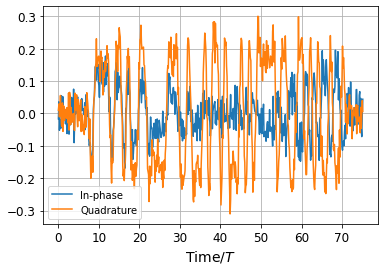

In [17]:
plt.plot(np.arange(len(rr))/fsT_r, np.real(rr), label="In-phase")
plt.plot(np.arange(len(rr))/fsT_r, np.imag(rr), label="Quadrature")
plt.grid()

plt.xlabel('Time/$T$')
plt.legend()

plt.show()

The delay is visible at the start of the received signal. The frequency shift manifests itself in the changing magnitudes of real and imaginary parts.

### Receiver Processing

The receiver first passes the received signal through the matched filter. The output from the matched filter is then separated into `fsT` sampling phases.


In [18]:
## matched filter
hh_r = srrc_pulse(0.5, fsT_r)  # filter for reduced sampling rate
mf_out = np.convolve(rr, np.flip(hh_r))

## divide MF output into fsT_r sampling phases
nT = len(mf_out) // fsT_r  # number of symbol periods for each phase
Z = np.zeros((fsT_r, nT), dtype=complex)
for n in range(fsT_r):
    Z[n, :] = mf_out[n : fsT_r*nT : fsT_r]

At this point, the matched filter outputs aren't very informative because of the frequency and phase shift present n the signal.

The plot below shows the magnitude of the matched filter outputs for each sampling phase.

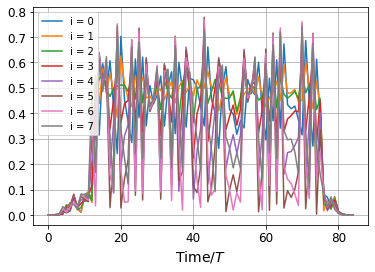

In [19]:
for n in range(fsT_r):
    plt.plot(np.arange(nT), np.abs(Z[n, :]), label='i = {:d}'.format(n))

plt.grid()

plt.xlabel('Time/$T$')
plt.legend()

plt.show()

#### Correlating against the Preamble sequence

Our initial goal is to locate the preamble. Towards that end, we must correlate each of the received phases against the preamble sequence. 

Recall that correlation with the preamble is equaivalent to convolving with the time-reversed, conjugate coplex of the preamble.

In [20]:
## correlate against the preamble sequence
D = np.zeros((fsT_r, nT + K - 1), dtype=complex)

for n in range(fsT_r):
    D[n, :] = np.convolve(Z[n,:], np.flip(np.conj(pn)))

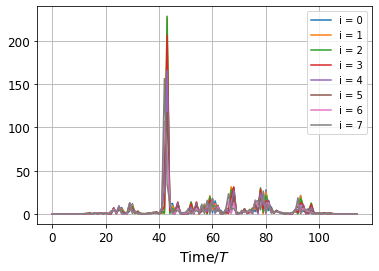

Tallest correlation peak is at n = 43 and i = 2


In [21]:
## plot the outputs from the correlation
for n in range(fsT_r):
    plt.plot(np.arange(nT+K-1), np.abs(D[n, :])**2, label='i = {:d}'.format(n))

plt.grid()

plt.xlabel('Time/$T$')
plt.legend()

plt.show()

# locate the tallest peak
max_n = np.argmax(np.abs(D[:, :])**2, axis=1)
max_i = np.argmax(np.array([np.abs(D[n, max_n[n]])**2 for n in range(fsT_r)]))
n_hat = max_n[max_i]
i_hat = max_i
print("Tallest correlation peak is at n = {:d} and i = {:d}".format(max_n[max_i], max_i))

Now, we can clearly see very strong correlation peaks. 

These peaks are located in symbol period $n=43$ and on sampling phase $i=1$ (the peak on phase $i=2$ is nearly identical).

Is this correct and, if so, what does it mean?

#### Interpreting the timing estimate

Let's begin by tallying up the sources of delay in the system:

1. The **channel delay** was set to 102 samples; that delay was applied at the original sampling rate of 32 samples per symbol period. Hence, this delay amounts to $\frac{102}{32} = 3.1875$ symbol periods.
2. The **filter delays** from pulse shaping and matched filtering contribute a combined delay of 10 symbol periods. Each filter impulse response spans 10 symbol periods.
3. The timing estimate can only be produced when the **last preamble symbol** is processed. In other words, the timing estimate points to the last symbol of the preamble. This induces a delay of $K-1 = 30$ symbol periods

Totaling up these delays, yields a combined delay of 43.1875 symbol periods.

So, $n=43$ indicates the number of full symbol periods in this delay. 

The fractional delay, 0.1875 symbol periods is captured by the optimum sampling phase. The time difference between two sampling phases is $\frac{1}{fsT}=\frac{1}{8}$ symbol periods. Hence, $i=1$ corresponds to 0.125 symbol periods and $i=2$ corresponds to 0.25 symbol periods. The observation that $i=1$ and $i=2$ have nearly identical correlation values suggests that the true delay is halfway between 0.125 symbol periods and 0.25 symbol periods.

#### Finding the start of the preamble

To perform estimation of the frequency, amplitude and phase, we need to find the matched filter output that cover the preamble symbols.

First off, $i=1$ tells us that we only need to concern ourselves with the matched filter outputs on sampling phase $i=1$.

*Remark:* as we observed above, $i=2$ is nearly equally good in terms of correlation. Therefore, we could *interpolate* between the two phases. This is not necessary when oversampling by 8. However, with less oversampling (especially, `fsT`=2) interpolation is important.

Second, the matched filter output that corresponds to the start of the preamble is located at time index $n=43-K+1=13$, i.e., we must subtract $K-1$ from the location of the correlation peak. 

The matched filter outputs to be used for further processing are, therefore, `Z[1, 13:44]` (recall that in Python, the last value in the range `13:44` is not included; i.e., the first information symbol is at $n=44$).

Let's verify that this is correct:

* we take the samples `Z[1, 13:44]` from the matched filter outputs that are supposed to contain the preamble 
* Then we multiply these sample by the (conjugate) of the preamble sequence - this strips of the modulation
* The products are plotted as an IQ scatter plot

The resulting IQ samples should form a cluster in the complex plane. The cluster will be rotated by phase error and spread out along a circle due to frequency error.

If we had the wrong samples, we would see two clusters.

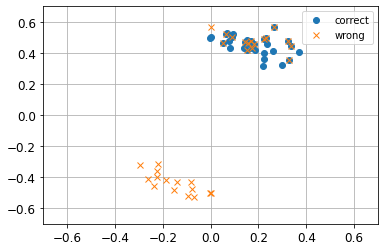

In [22]:
## check that we have the correct samples for the preamble.
first = n_hat - K + 1
last = n_hat + 1
ZZ = Z[1, first:last]
ZZ_pn = ZZ * pn.conj()
ZZ_wrong = Z[1, first+1:last+1] * pn.conj()

plt.plot(np.real(ZZ_pn), np.imag(ZZ_pn), 'o', label='correct')
plt.plot(np.real(ZZ_wrong), np.imag(ZZ_wrong), 'x', label='wrong')
plt.grid()
plt.xlim(-0.7, 0.7)
plt.ylim(-0.7, 0.7)
plt.legend()

plt.show()

### Estimating the frequency offset

Frequency offset manifests itself as a phase rotation that increases with time.

In each symbol period, the phase increases by $2\pi\Delta\, f T$ and, over the course of the length $K$ preamble, the phase change is $2\pi\Delta\, f (K-1) T$.

Hence, we can estimate the frequency offset $\Delta\, f$ from the phase difference between the first and last matched filter output during the preamble
$$
    \Delta\, f = \frac{\angle ((p_n^*[0]Z[1, 43]) \cdot (p_n^*[K-1]Z[1,13])^*)}{2 \pi (K-1)} 
$$

In [23]:
## Estimate the frequency offset
# phase difference between first and last symbol
d_phi = np.angle(pn[0]*Z[i_hat,n_hat] * np.conj(pn[-1]*Z[i_hat, first])) 

# frequency estimate
f_hat = d_phi / (2*np.pi*(K-1))

# display result
print('Estimated frequency offset: {:6.5f} (per T)'.format(f_hat))
print('phase change during preamble: {:4.3f} *2pi (True: {:4.1f} *2pi)'.format(d_phi/(2*np.pi), 0.1))

Estimated frequency offset: 0.00364 (per T)
phase change during preamble: 0.109 *2pi (True:  0.1 *2pi)


#### An improved frequency estimate

The estimate above has significant variance because there is very little averaging used in the estimate.

A better estimate computes multiple frequency estimates derived from samples that are spaced $L$ samples apart. 

There are $K-L$ pairs that can be formed from the preamble to compute such estimates. Note that the estimate above is the special case $L=K-1$.

The final estimate is the average over the individual estimates.

Here is a function to do that.

In [24]:
def est_freq(Z, pn, L=None):
    """Estimate frequency estimate from preamble samples

    Inputs:
    Z - matched filter outputs for preamble (taken at symbol period)
    pn - preamble sequence (same length as Z)
    L - spacing between samples to measure phase difference (default 2/3*K)

    Returns:
    float - frequency ofsset per symbol period
    """
    K = len(pn)

    if L is None:
        L = (2*K) // 3

    # make an array of all L-spaced phase differences
    dp = np.array( [ (pn[n+L]*Z[n+L]) * np.conj(pn[n]*Z[n]) for n in range(K-L) ] )

    return np.angle(np.mean(dp))/(2*L*np.pi)

In [25]:
# display result
f_hat = est_freq(Z[1, first:n_hat+1], pn)

print('Estimated frequency offset: {:6.5f} (per T)'.format(f_hat))
print('phase change during preamble: {:4.3f} *2pi (True: {:4.1f} *2pi)'.format(f_hat * (K-1), 0.1))


Estimated frequency offset: 0.00346 (per T)
phase change during preamble: 0.104 *2pi (True:  0.1 *2pi)


Let's verify that we can correct the effect of the frequency error, i.e., the changing phase, over the course of the preamble.

To do so, we multiply the matched filter output during the preamble by a complex exponential of (normalized to $1/T$) frequency `f_hat`.

The result should be a tight cluster without significant phase spreading.

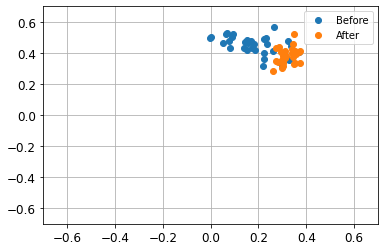

In [26]:
Z_corr = Z[1,first:n_hat+1] * np.exp(-2j * np.pi * f_hat * np.arange(K))
ZZ_corr_pn = Z_corr * pn.conj()

plt.plot(np.real(ZZ_pn), np.imag(ZZ_pn), 'o', label='Before')
plt.plot(np.real(ZZ_corr_pn), np.imag(ZZ_corr_pn), 'o', label='After')
plt.grid()
plt.xlim(-0.7, 0.7)
plt.ylim(-0.7, 0.7)
plt.legend()

plt.show()

### Estimating the amplitude and phase

The final estimation step is to measure the amplitude and phase from the frequency corrected preamble symbols.

This is what we discussed last time: in terms of the frequency corrected matched filter outputs `ZZ_corr_pn` that we just computed, the estimated amplitude and phase is simply the sum of the samples `ZZ_corr_pn` divided by the norm-squared of the preamble sequence. 

In [27]:
## Estimate amplitude and phase
X_hat = np.sum(ZZ_corr_pn) / np.sum(np.abs(pn)**2)

print("Estimated amplitude: {:4.3f}\nEstimated phase: {:4.3f} * pi".format(np.abs(X_hat), 
                                                                           np.angle(X_hat)/np.pi))
print("Corrected phasor X/X_hat = {:4.3f} + j {:4.3f}". format(np.real(X/X_hat), np.imag(X/X_hat)))

Estimated amplitude: 0.495
Estimated phase: 0.277 * pi
Corrected phasor X/X_hat = 1.007 + j -0.085


### Recovering the information symbols

The real objective of this process is to recover the information symbols; locating the preamble and estimating amplitude frequency and phase are merely enablers on the path to that objective.

We have learned 
* that we have to use the matched filter outputs from sampling phase $i=1$.
* The last sample of the preamble is $Z[1, 43]$; therefore, the information symbol must start at sample $n=44$
* with the estimated frequency offset, phase and amplitude we can make correcttions to the matched filter outputs

There is a subtlety involved in the frequency correction step: we computed the phase $\phi_p$ at the *start of the preamble*. However, we need the phase $\phi_s$ at the *start of the symbols*. Fortunately, there is a simple relationship between the two:
$$
    \phi_s = \phi_p + 2 \pi \Delta\, f KT.
$$
We can either incorporate the above in the complex amplitude estimate or we can start the sample numbers in the genaration of frequency correction at $K$.

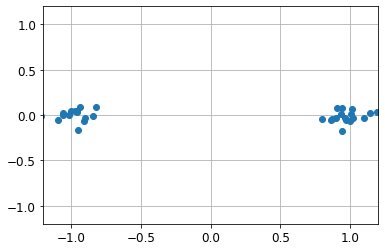

Found 0 errors


In [28]:
## Apply corrections in preparation for symbol demod
# get relevant matched filter outputs
Z_sym = Z[1, n_hat+1:n_hat+1+Ns]

# apply frequency and complex amplitude correction; 
# np.arange(K, K+Ns) accounts for the phase change during the pramble!
Z_sym = Z_sym / X_hat * np.exp(-2j * np.pi *f_hat *np.arange(K, K+Ns))

# scatter plot
plt.plot(np.real(Z_sym), np.imag(Z_sym), 'o', label='Symbols')
plt.grid()
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.show()

dec = MPE_decision_rule(Z_sym, A)
print("Found {:d} errors".format(np.sum(np.not_equal(dec, syms))))

## Summary

We have shown how to process the preamble to:
* find the location of the preamble; specifically we located the last sample of the preamble in the matched filter outputs
* Oversampled matched filter outputs allowed us to find the best sampling phase for down-sampling the matched filter outputs; this provides timing acquisition to a fraction of the symbol period.
* Once the preamble is located, the frequency offset can be estimated from phase differences between matched filter outputs (multiplied by the conjugate of the preamble sequence).
* With the estimate of the frequency offset, the amplitude and phase of the signal can be determined.
* That paves the way to apply all correction to the information bearing portion of the signal and recover the information symbols.

In practice, we must search for the preamble *sequentially*:
* In each sample period, compute one matched filter output and append this output to the observations for the respective sampling phase.
* measure the correlation of the $K$ most recent samples of that sampling phase with the preamble sequence.
* Compare the correlation value to a threshold: if the threshold is exceeded, the preamble is located at the current symbol period and on the current ampling phase.

After the preamble is detected, the frequency, amplitude and phase must be estimated. Only the optimal sampling phase must be considered going forward (at least until we start equalizing).